In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

/home/moses/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dfbikes = pd.read_csv('data/bay_area_bikeshare/201402_trip_data_v2.csv', parse_dates=['start_date'])

# EDA
Let's look at the distribution of bike trip duration (in seconds).

In [13]:
dfbikes['duration'].describe()

count    144015.000000
mean       1230.910141
std        6652.962329
min          60.000000
25%         349.000000
50%         531.000000
75%         797.000000
max      722236.000000
Name: duration, dtype: float64

Whoa, that max duration is way bigger than the median (~8 days versus ~9 minutes).
Trying to plot all the data at once in a histogram is inconvenient because of the very long tail, so let's cut it off at 3600.

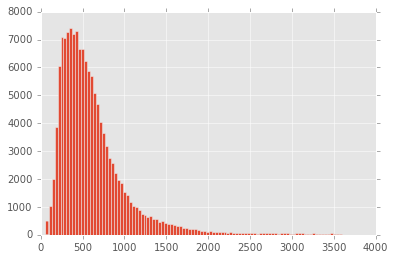

In [14]:
dfDuration[dfDuration <= 3600].hist(bins=100);

Let's get a closer look by changing our cutoff to 2000

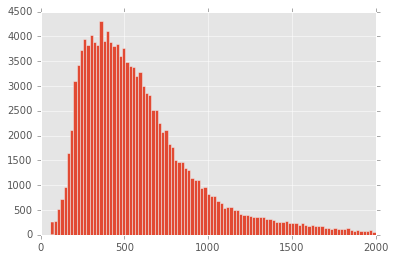

In [15]:
dfDuration[dfDuration <= 2000].hist(bins=100);

How many trips were above 3600, anyway?

In [17]:
print (dfDuration > 3600).sum()
print (dfDuration > 3600).mean()

5695
0.0395444918932


5695, or about 4%. Cool. Let's check out what time of day people tend to start their bike trips (by hour).

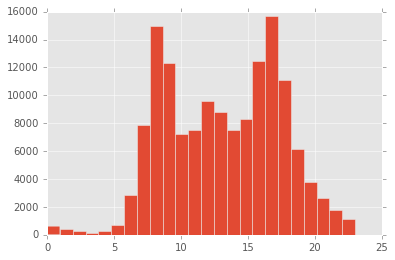

In [18]:
dfbikes['start_date'].dt.hour.hist(bins=24);

Big peaks at 8 AM to 9 AM and 5 PM to 6PM. Commuters!
Let's split up the data into Weekday and Weekend to see how big this commuter effect is.
I've already cast the date as a Timestamp object when importing, so now I can call Timestamp.weekday, which gives 0 for Monday and 6 for Sunday. 

In [21]:
dfWeekdaydata = dfbikes[dfbikes['start_date'].dt.weekday < 5] 
dfWeekenddata = dfbikes[dfbikes['start_date'].dt.weekday >= 5]

In [22]:
dfWeekdayhour = dfWeekdaydata['start_date'].dt.hour
dfWeekendhour = dfWeekenddata['start_date'].dt.hour

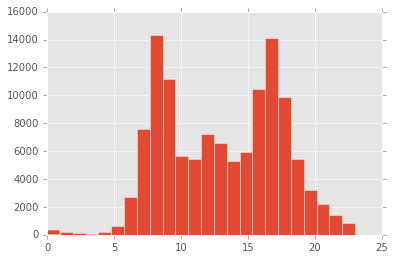

In [25]:
dfWeekdayhour.hist(bins=24);

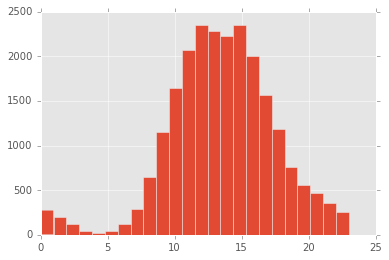

In [26]:
dfWeekendhour.hist(bins=24);

Look at that, people are free to structure their time during the weekend and they stay pretty centered around midday. I'd also wager that those are some late-night barhoppers and showgoers taking the midnight and 1AM bikes. TGIF, right?

For fun, let's also check out what kind of effect the weekend has on the ride duration.

In [30]:
dfWeekdaydata['duration'].describe()

count    121015.000000
mean       1012.765360
std        5680.684498
min          60.000000
25%         337.000000
50%         505.000000
75%         733.000000
max      619322.000000
Name: duration, dtype: float64

In [28]:
dfWeekenddata['duration'].describe()

count     23000.000000
mean       2378.683652
std       10285.571282
min          60.000000
25%         455.000000
50%         765.000000
75%        1389.250000
max      722236.000000
Name: duration, dtype: float64

Naturally, people have more time during the weekend for leisurely rides, and fewer are making the (hopefully) short-ish rides from their BART stop to their office. A weekend median of 765s bears this out compared to 505s, but perhaps more telling is the larger leap up of the 75th percentile to 1389 from 733. More people are hanging out in the longer-duration tail. Let's look at the histograms:

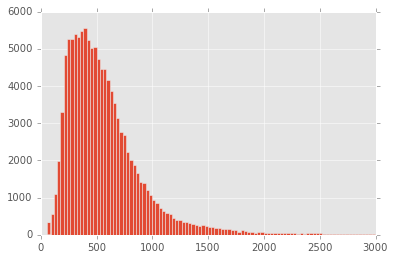

In [31]:
dfWeekdaydata[dfWeekdaydata['duration'] < 3000]['duration'].hist(bins=100);

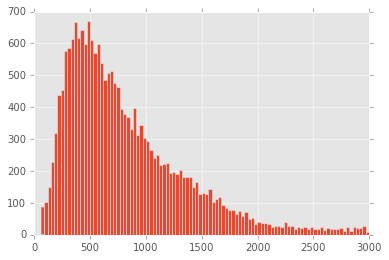

In [32]:
dfWeekenddata[dfWeekenddata['duration'] < 3000]['duration'].hist(bins=100);

# 2.
Let's look at the histograms of trip duration grouped by each city. The city is in the 'landmark' column of the 'station data' file, so let's load that and merge it with the trip data.

In [33]:
dfstations = pd.read_csv('data/bay_area_bikeshare/201402_station_data_v2.csv', parse_dates=['installation'])

In [34]:
dfbikewithstations = pd.merge(dfbikes, dfstations, left_on='start_terminal', right_on='station_id')

Let's only look at trips under 2000 seconds.

In [35]:
dfbikewithstationsubset = dfbikewithstations[dfbikewithstations['duration'] <= 2000]

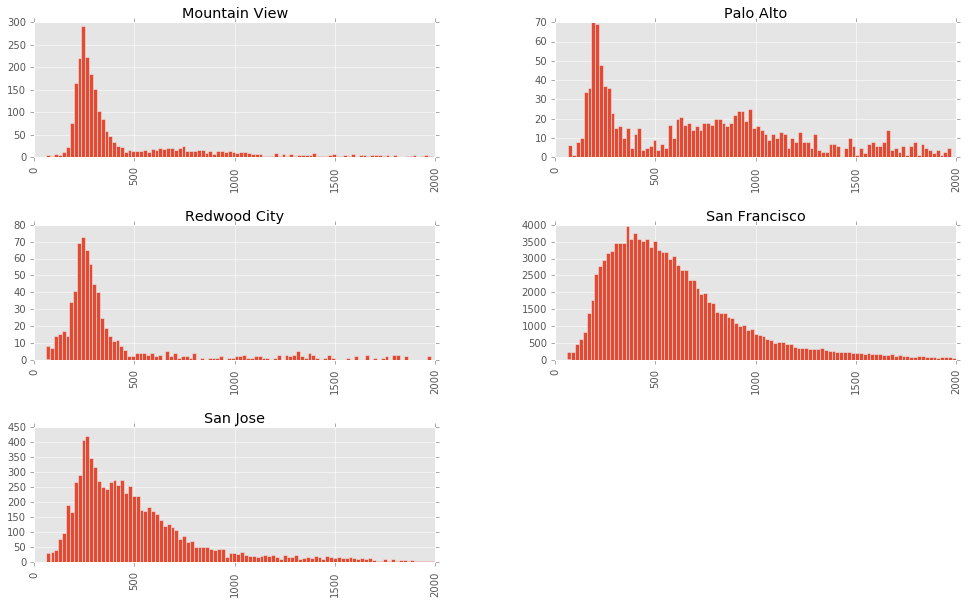

In [41]:
dfbikewithstationsubset.hist(column='duration', by='landmark', bins=100, figsize=(16,10));

#### SF's huge number of riders compared to the other cities gives it a smooth, less noisy distribution. Also the fact that it has more bike stations gives more variety to the possible trip routes. Palo Alto's numbers are very small, but might point to longer trip durations. Maybe they just got stations? Let's check the earliest station installation date in the data for each city.

In [44]:
dfbikewithstations.groupby('landmark').installation.min()

landmark
Mountain View   2013-08-15
Palo Alto       2013-08-14
Redwood City    2013-08-12
San Francisco   2013-08-19
San Jose        2013-08-05
Name: installation, dtype: datetime64[ns]

Hm, nope. How about the overall station count:

In [45]:
 dfbikewithstations.groupby('landmark')['name'].describe()

landmark             
Mountain View  count                                         2728
               unique                                           7
               top                 Mountain View Caltrain Station
               freq                                          1154
Palo Alto      count                                         1706
               unique                                           5
               top                         University and Emerson
               freq                                           434
Redwood City   count                                          793
               unique                                           7
               top                  Redwood City Caltrain Station
               freq                                           378
San Francisco  count                                       129853
               unique                                          35
               top       San Francisco Caltrain (Towns

Here we're only interested in the "unique" number. 7, 5, 7... no wonder. Here are the basic stats for each city, just 'cause.

In [46]:
dfbikewithstations.groupby('landmark')['duration'].describe()

landmark            
Mountain View  count      2728.000000
               mean       2681.418988
               std       17025.970019
               min          62.000000
               25%         246.000000
               50%         311.000000
               75%         785.000000
               max      586356.000000
Palo Alto      count      1706.000000
               mean       4635.689918
               std       27549.270494
               min          66.000000
               25%         363.250000
               50%         934.000000
               75%        2091.750000
               max      722236.000000
Redwood City   count       793.000000
               mean       2945.804540
               std       13995.149644
               min          60.000000
               25%         228.000000
               50%         284.000000
               75%         470.000000
               max      229914.000000
San Francisco  count    129853.000000
               mean       113